In [194]:
# Dependencies
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.inspection import PartialDependenceDisplay

import matplotlib.pyplot as plt


In [195]:
# Load the preprocessed features data
features_df = pd.read_csv('../data/processed/defenders_features.csv')

# Create a copy for a second run, but without bps influence
#features_run2_df = features_df.copy()


In [196]:
features_df.head(30)

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,ict_index_per_90,discrepancy_expected_actual_goals,goals_conceded_rolling_5,clean_sheets_rolling_5,yellow_cards_rolling_5,red_cards_rolling_5,defensive_effectiveness_rolling_5,defensive_effectiveness_trend,goals_conceded_trend,clean_sheets_trend
0,2016,17761,40,40,23,568,0,0,1,11,...,4.357394,-11.00,11.000000,1.000000,1.000000,0.000000,21.566197,NaN,NaN,NaN
1,2017,17761,45,46,101,2790,0,1,11,30,...,3.800000,-30.00,20.500000,6.000000,3.000000,0.000000,64.560518,42.994321,9.500000,5.000000
2,2018,17761,50,47,97,3086,3,2,7,63,...,4.505833,-63.00,34.666667,6.333333,4.666667,0.000000,77.755921,13.195403,14.166667,0.333333
3,2019,17761,50,55,143,3420,2,3,15,50,...,3.944737,-50.00,38.500000,8.500000,6.000000,0.000000,92.724835,14.968914,3.833333,2.166667
4,2020,17761,55,53,109,3240,1,0,11,50,...,3.547222,-50.00,40.800000,9.000000,6.000000,0.000000,95.453202,2.728366,2.300000,0.500000
5,2021,17761,50,49,83,3106,1,2,7,51,...,3.848036,-51.00,48.800000,10.200000,8.000000,0.000000,110.477966,15.024764,8.000000,1.200000
6,2022,17761,45,41,106,3420,1,1,9,57,...,4.394737,10.45,54.200000,9.800000,8.200000,0.000000,114.145946,3.667980,5.400000,-0.400000
7,2023,17761,45,46,117,3420,1,1,13,51,...,3.971053,4.64,51.800000,11.000000,8.800000,0.000000,119.196600,5.050655,-2.400000,1.200000
8,2006,18892,60,62,134,2780,5,6,0,38,...,0.000000,-38.00,38.000000,0.000000,3.000000,0.000000,-0.492086,NaN,NaN,NaN
9,2007,18892,70,75,177,3288,8,17,0,48,...,0.000000,-48.00,43.000000,0.000000,4.500000,0.000000,-0.508817,-0.016731,5.000000,0.000000


In [197]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   season_name                        725 non-null    int64  
 1   element_code                       725 non-null    int64  
 2   start_cost                         725 non-null    int64  
 3   end_cost                           725 non-null    int64  
 4   total_points                       725 non-null    int64  
 5   minutes                            725 non-null    int64  
 6   goals_scored                       725 non-null    int64  
 7   assists                            725 non-null    int64  
 8   clean_sheets                       725 non-null    int64  
 9   goals_conceded                     725 non-null    int64  
 10  own_goals                          725 non-null    int64  
 11  penalties_saved                    725 non-null    int64  

### Data Cleaning and Preprocessing

In [198]:
# Handling Missing Values
# Fill missing values in trend-related columns with zeroes
trend_columns = [
    'defensive_effectiveness_trend', 
    'goals_conceded_trend', 
    'clean_sheets_trend'
]

# Replace NaN with 0 in trend columns
features_df[trend_columns] = features_df[trend_columns].fillna(0)

In [199]:
# Dropping columns that are identifiers or don't contribute directly to the model
columns_to_drop = [
    'first_name_defender', 
    'second_name_defender', 
    'first_name_ref', 
    'second_name_ref', 
    'id_defender', 
    'id_ref', 
    'unique_id',
    'element_code'  
]


In [200]:
# Drop columns
features_df.drop(columns=columns_to_drop, inplace=True)

In [201]:
# Check the info to ensure that all the data types are numeric and that there no missing values
print(features_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   season_name                        725 non-null    int64  
 1   start_cost                         725 non-null    int64  
 2   end_cost                           725 non-null    int64  
 3   total_points                       725 non-null    int64  
 4   minutes                            725 non-null    int64  
 5   goals_scored                       725 non-null    int64  
 6   assists                            725 non-null    int64  
 7   clean_sheets                       725 non-null    int64  
 8   goals_conceded                     725 non-null    int64  
 9   own_goals                          725 non-null    int64  
 10  penalties_saved                    725 non-null    int64  
 11  penalties_missed                   725 non-null    int64  

### Prepare Features and Target Variable

Data Splitting Strategy:
* Training Set: This subset of the data is used to train the model. The model learns patterns from this data.
* Validation Set: This set is used during the training process to evaluate the model's performance and fine-tune hyperparameters. It acts as a checkpoint to prevent overfitting to the training data.
* Testing Set: After the model is trained and fine-tuned, the testing set is used to evaluate its performance. The testing set should be completely unseen during the training and validation phases to provide an unbiased evaluation.

Data Splitting Approach:
* Training + Validation Set: 80% of the data.
* Testing Set: 20% of the data.
* Training Set: 75% of the training+validation set (60% of the original data).
* Validation Set: 25% of the training+validation set (20% of the original data).

In [202]:
# Define the target variable as 'defensive_effectiveness'
target_variable = 'defensive_effectiveness'

# Define the feature columns by excluding the target variable and identifier column
feature_columns = features_df.columns.drop([target_variable])


In [203]:
# Extract features (X) and target (y)
X = features_df[feature_columns]
y = features_df[target_variable]

# Split data into training+validation and testing sets (80-20 split)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into training and validation sets (75-25 split of training set)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Print out the size of each set to verify the splitting
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 435
Validation set size: 145
Testing set size: 145


### Model 1 (Decision Stumps with AdaBoost...sorta)
Decision stumps are a model that's used as weak learners in ensemble methods like boosting. A decision stump is a one-level decision tree, which means it makes a decision based on just a single feature.  When combined with a model like AdaBoost, the stumps can create an ensemble model that's capable of capturing complex patterns.

In [204]:
# Set up the Pipeline for preprocessing and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=1),
        n_estimators=100,
        random_state=42
    ))
])

# Train the model using the training set
pipeline.fit(X_train, y_train)

# Evaluate the model using the validation set
val_score = pipeline.score(X_val, y_val)
print(f"Validation R^2 score: {val_score}")

# Evaluate the test set
test_score = pipeline.score(X_test, y_test)
print(f"Testing R^2 score: {test_score}")

Validation R^2 score: 0.742454216773042
Testing R^2 score: 0.7228675665681874


#### Tuning the model
Parameters:
* n_estimators: Number of weak learners (i.e., Decision Stumps) to use. Test increasing this number to see if more iterations improves performance.
* max_depth: Maximum depth of the Decision Tree. The current depth is set to 1 (stumps), test slightly increasing to see if it captures more complex patterns.
* learning_rate: Determines the contribution of each tree. Lowering this rate while increasing n_estimators can help fine-tune the model's performance.

In [205]:
# Define the grid for tuning
param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.5, 1],
    'model__estimator__max_depth': [1, 2, 3]  # Depth of Decision Tree 1 for Stumps and experimented with shallow trees
}

# Set up the Pipeline for preprocessing and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', AdaBoostRegressor(
        estimator=DecisionTreeRegressor(),
        random_state=42
    ))
])

# Set up Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

# Run Grid Search
grid_search.fit(X_train_val, y_train_val)

# Best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best R^2 score from Grid Search: {grid_search.best_score_}")

# Evaluate the model on the test set using the best found parameters
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Testing R^2 score with best parameters: {test_score}")

Best parameters found: {'model__estimator__max_depth': 3, 'model__learning_rate': 0.5, 'model__n_estimators': 100}
Best R^2 score from Grid Search: 0.9960925691400693
Testing R^2 score with best parameters: 0.995359224393666


In [206]:
# Using the best model from GridSearchCV
cross_val_scores = cross_val_score(best_model, X_train_val, y_train_val, cv=5, scoring='r2')

print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2 score: {cross_val_scores.mean()}")

Cross-Validation R^2 scores: [0.99674591 0.99527227 0.99584883 0.99791449 0.99468134]
Mean Cross-Validation R^2 score: 0.9960925691400693


#### Insights
* High Predictive Power: The R^2 scores close to 1.0 indicates that the model explains a substantial amount of the variance in 'defensive_effectiveness'. The selected features and model configuration seem good for predicting defensive effectiveness.
* Consistency: The similar R^2 scores across training, validation, and testing sets show that the model is not overfitting. It generalizes well to new, unseen data.
* Tuning: The grid search successfully identified optimal hyperparameters leading to significant performance improvements.

#### Model Evaluation
1. Determine which features contribute most to the model's predictive power
2. Use Partial Dependence Plots (PDPs) to visualize the relationship between individual features and the predicted outcome

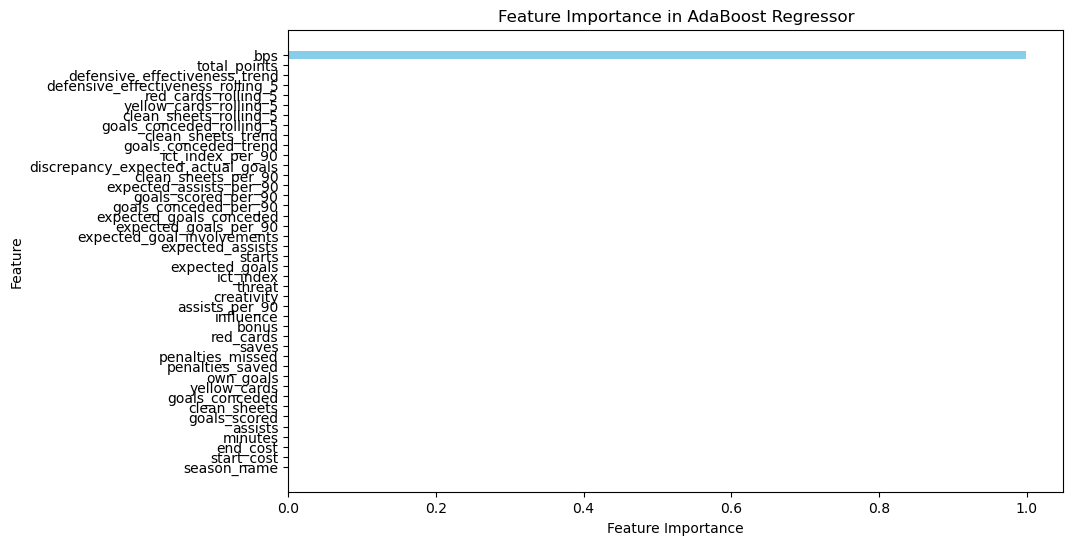

In [207]:
# Extract feature importances from the best model
feature_importances = best_model.named_steps['model'].feature_importances_
features = X.columns

# Sort features by importance
indices = np.argsort(feature_importances)[::-1]
sorted_features = [features[i] for i in indices]
sorted_importances = feature_importances[indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in AdaBoost Regressor')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()

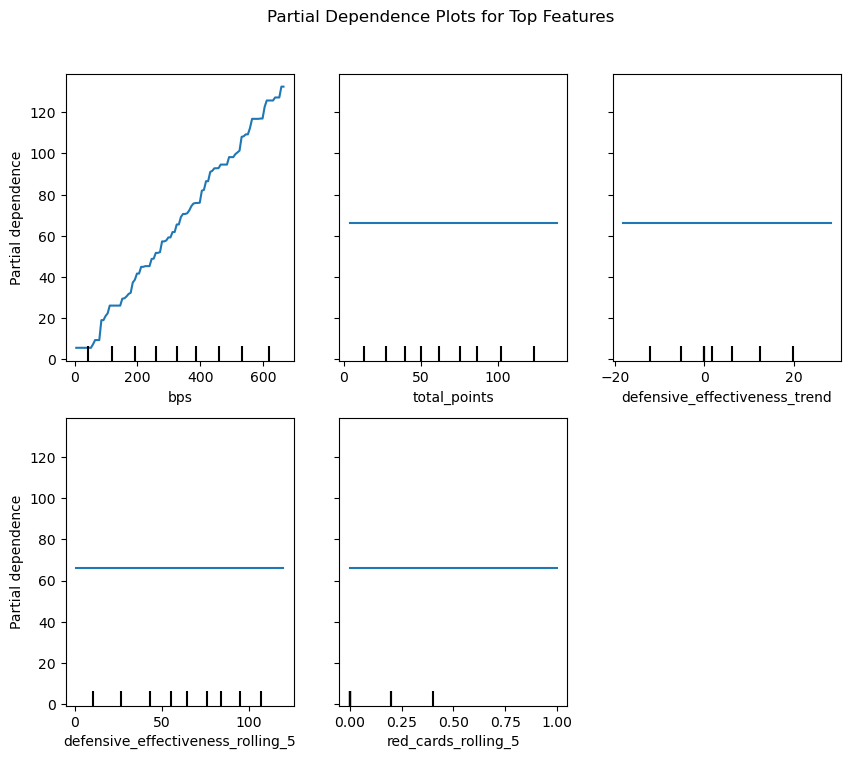

In [208]:
# Plot PDPs for the top features by importance
features_to_plot = sorted_features[:5]  # Top 5 features

# Plot Partial Dependence
fig, ax = plt.subplots(figsize=(10, 8))
PartialDependenceDisplay.from_estimator(best_model, X_train, features_to_plot, ax=ax)
plt.suptitle('Partial Dependence Plots for Top Features')
plt.subplots_adjust(top=0.9)
plt.show()

#### Observations:
1. The Bonus Points System (BPS) feature is the primary predictor in the model.
2. Features, such as total_points, defensive_effectiveness_trend, and rolling averages, have very low importance scores compared to BPS; these features contribute minimally to the model's predictions.
3. The PDP for BPS shows a positive, almost linear relationship. As BPS increases, the defensive effectiveness also increases, which indicates that players who accumulate more bonus points have higher defensive effectiveness.
4. Other features show flat partial dependence plots, suggesting no meaginful impact on the predicted defensive effectiveness.

#### Interpretations:
1. The model's heavy reliance on the BPS feature suggests that it may be oversimplifying the problem. This reliance could lead to overfitting, and may not generalize to new data.
2. The low importance of other features suggests that they might not be represented effectively or are not strong predictors.
3. Techniques like Principal Component Analysis (PCA) could help to identify underlying patterns in the data

#### Conclusion
* While the AdaBoost model with Decision Stumps achieved high R^2 scores on both validation and testing data, indicating good predictive performance, the feature importance analysis suggests that the model's understanding of defensive effectiveness is highly skewed towards the BPS metric making other features irrelevant.
* Next steps may involve re-evaluating the features and/or re-architecting the model.

### Model 2: Random Forest Regressor

In [209]:
# Set up the Pipeline for preprocessing and modeling
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', RandomForestRegressor(random_state=42)) 
])

In [210]:
# Define the parameter grid for GridSearchCV
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],  # The number of trees in the forest.
    'model__max_depth': [None, 10, 20, 30],  # The maximum depth of each decision tree. 'None' is no limit on the depth of the tree. 
    'model__min_samples_split': [2, 5, 10],  # Increasing this number prevents the model from learning overly specific patterns that could lead to overfitting.
    'model__min_samples_leaf': [1, 2, 4],    # Setting a minimum number of samples per leaf prevents the model from learning noise in the data. Larger minimum leaf sizes can make the model more robust.
}

In [211]:
# Set up GridSearchCV with cross-validation
grid_search_rf = GridSearchCV(estimator=pipeline_rf, 
                              param_grid=param_grid_rf, 
                              cv=5, 
                              n_jobs=-1, 
                              scoring='r2', 
                              verbose=2
                              )


In [212]:
# Train the model using GridSearchCV on the training set
grid_search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   1.6s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   1.7s
[CV] END model__max_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20, 30],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [213]:
# Extract the best parameters and model
best_rf_model = grid_search_rf.best_estimator_
print(f"Best parameters found: {grid_search_rf.best_params_}")
print(f"Best R^2 score from Grid Search: {grid_search_rf.best_score_}")


Best parameters found: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best R^2 score from Grid Search: 0.9973922139123399


Best Parameters:
* max_depth = None: The model is using fully grown trees without any restriction on the maximum depth. This indicates that the model benefits from capturing complex patterns without pruning the trees.
* min_samples_leaf = 2: Each leaf node must have at least 2 samples, which helps to prevent overfitting by ensuring that each terminal node is based on more than one data point.
* min_samples_split = 2: A node requires at least 2 samples to split, allowing for maximum tree branching and complexity.
* n_estimators = 100: Using 100 trees in the forest is the optimal balance for performance.

Best R^2 Score from Grid:
* This score indicates that the Random Forest model was able to explain about 99.74% of the variance in the validation dataset during the grid search, which suggests that the model is highly capable of capturing the underlying patterns in the data.


In [214]:
# Evaluate the best model on the validation set
val_score_rf = best_rf_model.score(X_val, y_val)
print(f"Validation R^2 score with best parameters: {val_score_rf}")


Validation R^2 score with best parameters: 0.9973620367981813


* The R^2 score on the validation set with the best parameters is very close to the score found during grid search. This consistency indicates that the model's performance is stable and not overfitted to the training data.

In [215]:
# Evaluate the best model on the test set
test_score_rf = best_rf_model.score(X_test, y_test)
print(f"Testing R^2 score with best parameters: {test_score_rf}")


Testing R^2 score with best parameters: 0.9982576026790495


The R^2 score on the testing set is even higher than the validation score, suggesting that the model generalizes exceptionally well to unseen data. This indicates that the model is very accurate and robust.

In [216]:
# Cross-validation to assess model performance stability
cv_scores_rf = cross_val_score(best_rf_model, X_train_val, y_train_val, cv=5, scoring='r2')
print(f"Cross-Validation R^2 scores: {cv_scores_rf}")
print(f"Mean Cross-Validation R^2 score: {np.mean(cv_scores_rf)}")


Cross-Validation R^2 scores: [0.99774959 0.99984046 0.99784117 0.99869924 0.99943867]
Mean Cross-Validation R^2 score: 0.9987138247236699


These scores are all extremely high.

#### Feature Importance


In [217]:
# Extract feature importances
feature_importances_rf = best_rf_model.named_steps['model'].feature_importances_
feature_names = X.columns

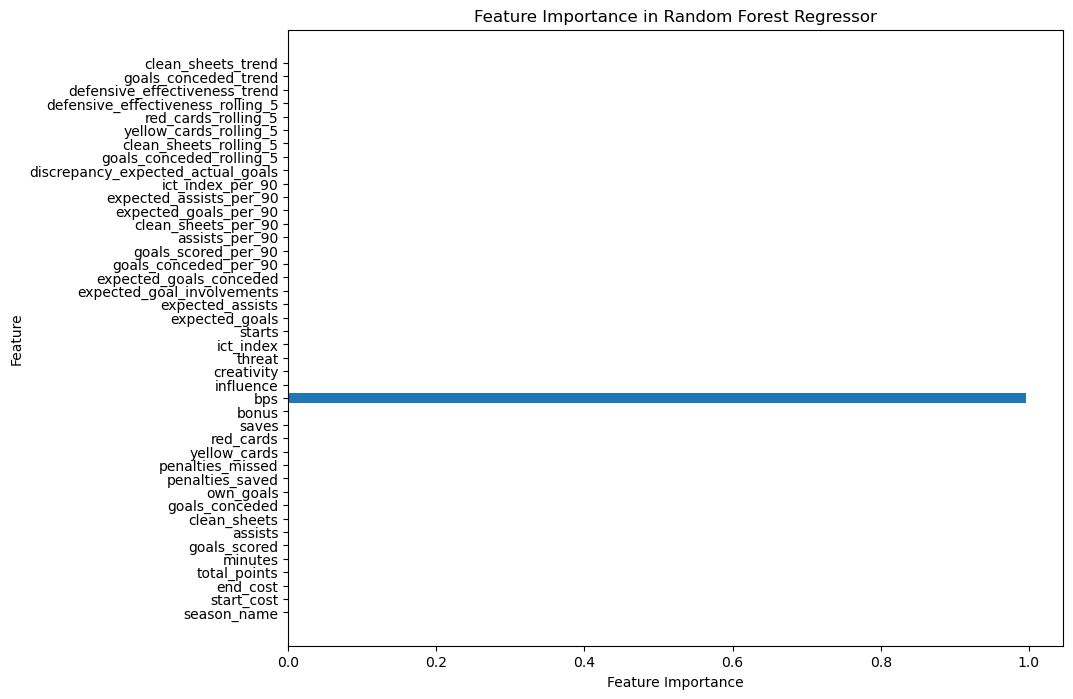

In [218]:
# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_importances_rf)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()

#### Oberservations
* features like "defensive_effectiveness_trend", "goals_conceded_trend", and "clean_sheets_trend" have no impact in the presence of "bps." It suggests that these features may already represented within the "bps" metric or that they do not add significant new information to improve the prediction.

#### Interpretation
The model's reliance on "bps" might indicate an overfitting tendency towards this single feature, which could limit the model's ability to generalize.

#### Conclusion
Consider running experiments by excluding "bps" from the feature set.

### Model 3: Ridge Regression
* Since non-linear models were used in Models 1 and 2 (Decision Stumps with AdaBoost and Random Forest), Ridge Regression provides a simpler linear model approach.
* Note: exclude the "bps" feature to explore how well the model performs without relying heavily on this single feature.

In [219]:
# Set up the Pipeline for preprocessing and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())             # Ridge Regression Model
])

In [220]:
# Define the parameter grid for GridSearchCV
# Different values of alpha -- 
# Larger values of alpha impose a greater penalty, which helps to 
# reduce overfitting and discourages overly complex models.
param_grid_ridge = {
    'model__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]  
}

In [221]:
# Set up GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(pipeline, param_grid_ridge, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]},
             scoring='r2')

In [222]:
# Print the best parameters and R^2 score from Grid Search
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best R^2 score from Grid Search: {grid_search.best_score_}")

Best parameters found: {'model__alpha': 0.1}
Best R^2 score from Grid Search: 0.9999933805140643


The best R^2 score from Grid Search is 0.999993, indicating the model explains nearly all the variance in the training data.

In [223]:
# Evaluate the model using the validation set
val_score = grid_search.score(X_val, y_val)
print(f"Validation R^2 score with best parameters: {val_score}")


Validation R^2 score with best parameters: 0.9999983862703336


The validation R^2 score being close to the best R² score from the grid search suggests that the model generalizes very well to unseen data.

In [224]:
# Evaluate the model using the test set
test_score = grid_search.score(X_test, y_test)
print(f"Testing R^2 score with best parameters: {test_score}")


Testing R^2 score with best parameters: 0.9999988118971095


The fact that the testing R^2 score is consistent with both the training and validation scores suggests that the model generalizes exceptionally well to completely unseen data. 

In [225]:
# Cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, X_train_val, y_train_val, cv=5, scoring='r2')
print(f"Cross-Validation R^2 scores: {cv_scores}")
print(f"Mean Cross-Validation R^2 score: {cv_scores.mean()}")

Cross-Validation R^2 scores: [0.99999904 0.99999643 0.9999979  0.99999957 0.99999429]
Mean Cross-Validation R^2 score: 0.9999974443281257


The individual Cross-Validation R² scores are all very close to 1, which suggests that the model's performance does not significantly vary across different subsets of the data.

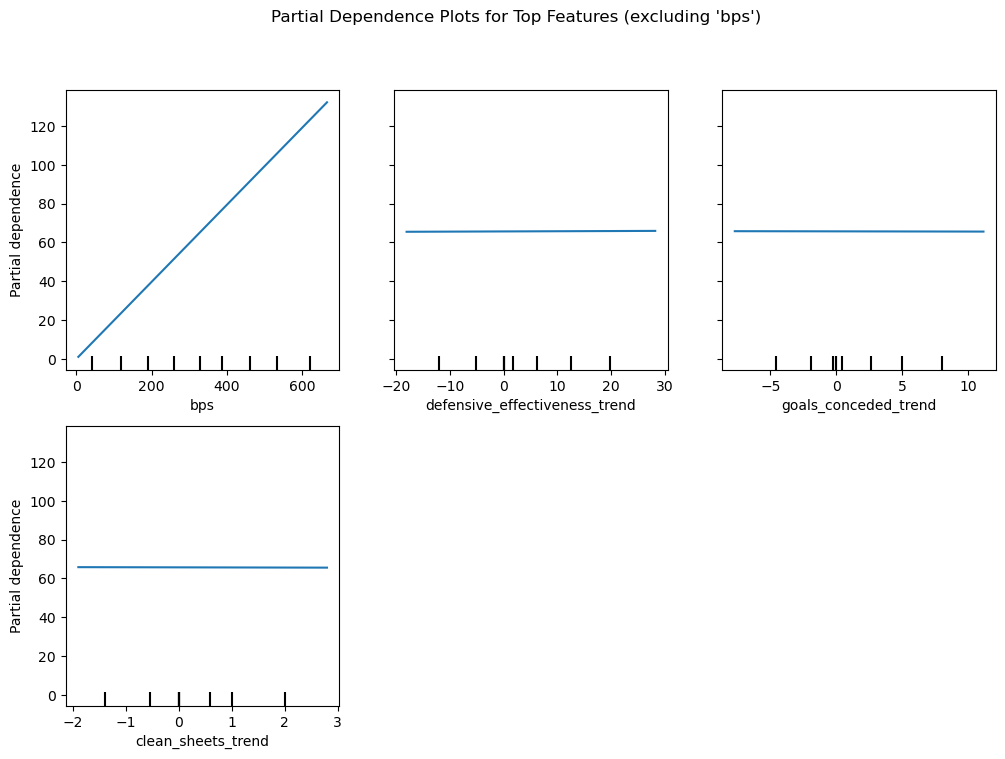

In [226]:
# Visual Validation using Partial Dependence Plots
# Selecting the top features based on the Ridge model coefficients for PDP

# Best model after Grid Search
best_ridge_model = grid_search.best_estimator_

# Select top features for partial dependence plots, including 'bps'
top_features = ['bps', 'defensive_effectiveness_trend', 'goals_conceded_trend', 'clean_sheets_trend']

# Plot Partial Dependence
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(best_ridge_model, X_train, features=top_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top Features (excluding 'bps')")
plt.show()

#### Observations
* As with other models "bps" overshaddows all other features.

#### Conclusion
* eliminate pbs from the models and evaluate findings.

## Re-Run the Models without bps and defensive effectiveness influence

In [227]:
# Load the preprocessed features data
features_run2_df = pd.read_csv('../data/processed/defenders_features.csv')


In [228]:
features_run2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   season_name                        725 non-null    int64  
 1   element_code                       725 non-null    int64  
 2   start_cost                         725 non-null    int64  
 3   end_cost                           725 non-null    int64  
 4   total_points                       725 non-null    int64  
 5   minutes                            725 non-null    int64  
 6   goals_scored                       725 non-null    int64  
 7   assists                            725 non-null    int64  
 8   clean_sheets                       725 non-null    int64  
 9   goals_conceded                     725 non-null    int64  
 10  own_goals                          725 non-null    int64  
 11  penalties_saved                    725 non-null    int64  

In [229]:
# List of columns to drop
columns_to_drop = ['bonus', 
                   'bps',
                   'clean_sheets', 
                   'clean_sheets_trend', 
                   'clean_sheets_rolling_5', 
                   'defensive_effectiveness', 
                   'defensive_effectiveness_rolling_5', 
                   'defensive_effectiveness_trend',
                   'discrepancy_expected_actual_goals', 
                   'element_code', 
                   'end_cost', 
                   'expected_assists', 
                   'expected_goals', 
                   'expected_goal_involvements', 
                   'expected_assists_per_90', 
                   'expected_goals_per_90', 
                   'first_name_defender', 
                   'first_name_ref',
                   'id_defender', 
                   'id_ref', 
                   'season_name',
                   'second_name_defender',  
                   'second_name_ref',  
                   'start_cost', 
                   'total_points',
                   'unique_id',
                   ]


# Drop the specified columns
features_run2_df.drop(columns=columns_to_drop, inplace=True)

### Handling Missing Values


In [230]:
# Fill missing values in trend-related columns with zeroes
trend_columns = [
    'goals_conceded_trend', 
#    'clean_sheets_trend'
]

# Replace NaN with 0 in trend columns
features_run2_df[trend_columns] = features_run2_df[trend_columns].fillna(0)

# Check for missing values
#missing_values = features_run2_df.isnull().sum()
#print(f"Missing values in each column:\n{missing_values}")

In [231]:
features_run2_df.head()

,minutes,goals_scored,assists,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,...,expected_goals_conceded,goals_conceded_per_90,goals_scored_per_90,assists_per_90,clean_sheets_per_90,ict_index_per_90,goals_conceded_rolling_5,yellow_cards_rolling_5,red_cards_rolling_5,goals_conceded_trend
0,568,0,0,11,0,0,0,1,0,0,...,0.0,1.742958,0.000000,0.000000,0.158451,4.357394,11.000000,1.000000,0.0,0.000000
1,2790,0,1,30,0,0,0,5,0,0,...,0.0,0.967742,0.000000,0.032258,0.354839,3.800000,20.500000,3.000000,0.0,9.500000
2,3086,3,2,63,0,0,0,8,0,0,...,0.0,1.837330,0.087492,0.058328,0.204148,4.505833,34.666667,4.666667,0.0,14.166667
3,3420,2,3,50,0,0,0,10,0,0,...,0.0,1.315789,0.052632,0.078947,0.394737,3.944737,38.500000,6.000000,0.0,3.833333
4,3240,1,0,50,0,0,0,6,0,0,...,0.0,1.388889,0.027778,0.000000,0.305556,3.547222,40.800000,6.000000,0.0,2.300000


In [232]:
# Define the target variable as 'clean_sheets_per_90'
target_variable = 'clean_sheets_per_90'

In [233]:
# Define the feature columns (everything except the target variable)
feature_columns = features_run2_df.columns.drop([target_variable])


In [234]:
# Extract features (X) and target (y)
X = features_run2_df[feature_columns]
y = features_run2_df[target_variable]


In [235]:
# Split the data into training and testing sets (80-20 split)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into training and validation sets (75-25 split of the training set)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [236]:
# Print out the number of rows of each set to verify the splitting
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 435
Validation set size: 145
Testing set size: 145


### Model 4 (a re-do of Model 1 with updated features): Decision Stumps with AdaBoost

In [237]:
# Grid for hyperparameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200, 300],  # Number of boosting rounds
    'model__learning_rate': [0.01, 0.1, 0.5, 1],  # Shrinks the contribution of each tree
    'model__estimator__max_depth': [1, 2, 3]  # Depth of Decision Tree (1 for Stumps)
}

In [238]:
# Pipeline that includes feature scaling and AdaBoost with Decision Stumps
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', AdaBoostRegressor(
        estimator=DecisionTreeRegressor(),  # Base estimator (decision tree)
        random_state=42
    ))
])


In [239]:
# Set up Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    pipeline,  # The model pipeline
    param_grid,  # The parameter grid to search over
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R-squared to evaluate models
    n_jobs=-1  # Run jobs in parallel
)

In [240]:
# Run Grid Search
grid_search.fit(X_train_val, y_train_val)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        AdaBoostRegressor(estimator=DecisionTreeRegressor(),
                                                          random_state=42))]),
             n_jobs=-1,
             param_grid={'model__estimator__max_depth': [1, 2, 3],
                         'model__learning_rate': [0.01, 0.1, 0.5, 1],
                         'model__n_estimators': [50, 100, 200, 300]},
             scoring='r2')

In [241]:
# Print the best hyperparameters and the best R^2 score found by Grid Search
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best R^2 score from Grid Search: {grid_search.best_score_}")

Best parameters found: {'model__estimator__max_depth': 3, 'model__learning_rate': 0.01, 'model__n_estimators': 300}
Best R^2 score from Grid Search: 0.5419644729005251


Iteration 1: The model explains 83.9% of the variance in the target variable (clean_sheets_per_90) on the training/validation data.

Iteration 2: Removed additional features including these, which are closly tied to the target: 'clean_sheets', 'clean_sheets_trend' 'clean_sheets_rolling_5'. The model now only explains 54.2% of the variance, and so its ability to to explain the variance in the target variable has been significantly diminished.

In [242]:
# Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_

In [243]:
# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)
print(f"Testing R^2 score with best parameters: {test_score}")


Testing R^2 score with best parameters: 0.48380891681291927


Iteration 1: The decrease in performance (79.1%)from the best score might indicate some degree of overfitting. However, it leaves 20.9% of the variance in the target variable unexplained.

Iteration 2: At 48.4% the model is explaining less than half of the variance of the test data.  The model is underperforming.

In [244]:
# Perform 5-fold cross-validation on the training+validation set to assess model performance stability
cross_val_scores = cross_val_score(best_model, X_train_val, y_train_val, cv=5, scoring='r2')

# Print cross-validation scores and their mean
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2 score: {cross_val_scores.mean()}")


Cross-Validation R^2 scores: [0.56721672 0.4903243  0.52376355 0.58268657 0.54583123]
Mean Cross-Validation R^2 score: 0.5419644729005251


Iterations 1 & 2: The model's performance is relatively consistent across different data subsets.  Refining feature selection and experimenting with the model design might yield improvments.

### Visualize Feature Importance

In [245]:
# Extract feature importances
#feature_importances = best_model.named_steps['model'].feature_importances_
#features = X.columns

feature_importances_2 = best_model.named_steps['model'].feature_importances_
features_2 = X.columns

In [246]:
# Sort features by importance
#indices = np.argsort(feature_importances)[::-1]
#sorted_features = [features[i] for i in indices]
#sorted_importances = feature_importances[indices]

indices_2 = np.argsort(feature_importances_2)[::-1]
sorted_features_2 = [features_2[i] for i in indices_2]
sorted_importances_2 = feature_importances_2[indices_2]

Clean sheets, goals conceded, and minutes played are the driving forces behind predictions.

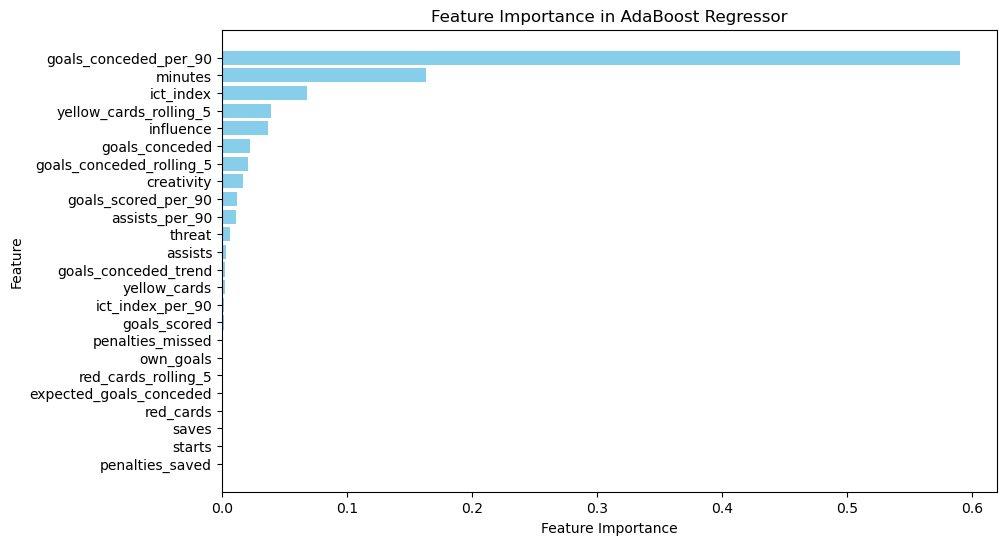

In [247]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features_2, sorted_importances_2, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in AdaBoost Regressor')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()

goals_conceded_per_90 is by far the most dominant feature, which makes sense for predicting clean sheets.

It might be worthwhile to feature re-engineer or experiment with feature reduction methods (e.g., PCA).  The model design of Decision Stumps with an AdaBoost Regressor model may not be ideal.

### Model 5: Random Forest Regressor with refined features

In [248]:
# Load the preprocessed features data
#features_run2_df = pd.read_csv('../data/processed/defenders_features.csv')

In [249]:
#features_run2_df.columns

In [250]:
# Handling Missing Values (refactor)
#trend_columns = ['defensive_effectiveness_trend', 'goals_conceded_trend', 'clean_sheets_trend']
#features_run2_df[trend_columns] = features_run2_df[trend_columns].fillna(0)

In [251]:
# List of columns to drop
"""
columns_to_drop = ['bonus', 
                   'bps',
                   'clean_sheets', 
                   'clean_sheets_trend', 
                   'clean_sheets_rolling_5', 
                   'defensive_effectiveness', 
                   'defensive_effectiveness_rolling_5', 
                   'defensive_effectiveness_trend',
                   'discrepancy_expected_actual_goals', 
                   'element_code', 
                   'end_cost', 
                   'expected_assists', 
                   'expected_goals', 
                   'expected_goal_involvements', 
                   'expected_assists_per_90', 
                   'expected_goals_per_90', 
                   'first_name_defender', 
                   'first_name_ref', 
                   'id_defender', 
                   'id_ref', 
                   'season_name',
                   'second_name_defender',  
                   'second_name_ref',  
                   'start_cost', 
                   'total_points',
                   'unique_id',
                   ]
"""

"\ncolumns_to_drop = ['bonus', \n                   'bps',\n                   'clean_sheets', \n                   'clean_sheets_trend', \n                   'clean_sheets_rolling_5', \n                   'defensive_effectiveness', \n                   'defensive_effectiveness_rolling_5', \n                   'defensive_effectiveness_trend',\n                   'discrepancy_expected_actual_goals', \n                   'element_code', \n                   'end_cost', \n                   'expected_assists', \n                   'expected_goals', \n                   'expected_goal_involvements', \n                   'expected_assists_per_90', \n                   'expected_goals_per_90', \n                   'first_name_defender', \n                   'first_name_ref', \n                   'id_defender', \n                   'id_ref', \n                   'season_name',\n                   'second_name_defender',  \n                   'second_name_ref',  \n                   'start_cos

In [252]:
# Set up the Pipeline for preprocessing and modeling
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', RandomForestRegressor(random_state=42)) 
])

In [253]:
# Define the parameter grid for GridSearchCV
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],  # The number of trees in the forest.
    'model__max_depth': [None, 10, 20, 30],  # The maximum depth of each decision tree. 'None' is no limit on the depth of the tree. 
    'model__min_samples_split': [2, 5, 10],  # Increasing this number prevents the model from learning overly specific patterns that could lead to overfitting.
    'model__min_samples_leaf': [1, 2, 4],    # Setting a minimum number of samples per leaf prevents the model from learning noise in the data. Larger minimum leaf sizes can make the model more robust.
}

In [254]:
# Set up GridSearchCV with cross-validation
grid_search_rf = GridSearchCV(estimator=pipeline_rf, 
                              param_grid=param_grid_rf, 
                              cv=5,         # 5-fold cross-validation
                              n_jobs=-1,    # Run in parallel
                              scoring='r2', # R-squared as evaluation metric
                              verbose=2
                              )


In [255]:
# Train the model using GridSearchCV on the training set
grid_search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.6s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.6s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.6s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.6s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.7s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   1.3s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   1.3s
[CV] END model__max_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20, 30],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [256]:
# Extract the best parameters and model
best_rf_model = grid_search_rf.best_estimator_
print(f"Best parameters found: {grid_search_rf.best_params_}")
print(f"Best R^2 score from Grid Search: {grid_search_rf.best_score_}")


Best parameters found: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best R^2 score from Grid Search: 0.5219172315382388


The model is not highly effective in explaining all the variability in 'clean_sheets_per_90'. It leaves a significant amount of variance unexplained and so the model's predictive power is limited.

May need to engineer new features to provide more explanatory power for the target. Could also explore models that capture different types of relationships, such as Gradient Boosting and will try Ridge (linear) next.

In [257]:
# Evaluate the best model on the validation set
val_score_rf = best_rf_model.score(X_val, y_val)
print(f"Validation R^2 score with best parameters: {val_score_rf}")


Validation R^2 score with best parameters: 0.7025108545326331


The model is able to explain approximately 70.25% of the variance in the target.  This is a substantial improvement over the training R^2 score of around 0.52 from Grid Search. It indicates the model is capturing a significant portion of the variance in the target variable.

The increase in the score from training (0.52) to validation (0.70) is positive and suggests that the hyperparameters are well-tuned to generalizing to the validation set.

There is still a lot of room for improvement.

In [258]:
# Evaluate the best model on the test set
test_score_rf = best_rf_model.score(X_test, y_test)
print(f"Testing R^2 score with best parameters: {test_score_rf}")


Testing R^2 score with best parameters: 0.4658753849730285


The significant drop in R^2 score from validation to testing suggests that while the model parameters seemed optimal for a portion of the data, they did not perform as well when generalized to the testing set.

In [259]:
# Cross-validation to assess model performance stability
cv_scores_rf = cross_val_score(best_rf_model, X_train_val, y_train_val, cv=5, scoring='r2')
print(f"Cross-Validation R^2 scores: {cv_scores_rf}")
print(f"Mean Cross-Validation R^2 score: {np.mean(cv_scores_rf)}")


Cross-Validation R^2 scores: [0.6336124  0.44336195 0.52998294 0.5911364  0.53684845]
Mean Cross-Validation R^2 score: 0.5469884295587951


Back to the drawing board :/

In [260]:
# Extract feature importances
feature_importances_rf = best_rf_model.named_steps['model'].feature_importances_
feature_names = X.columns

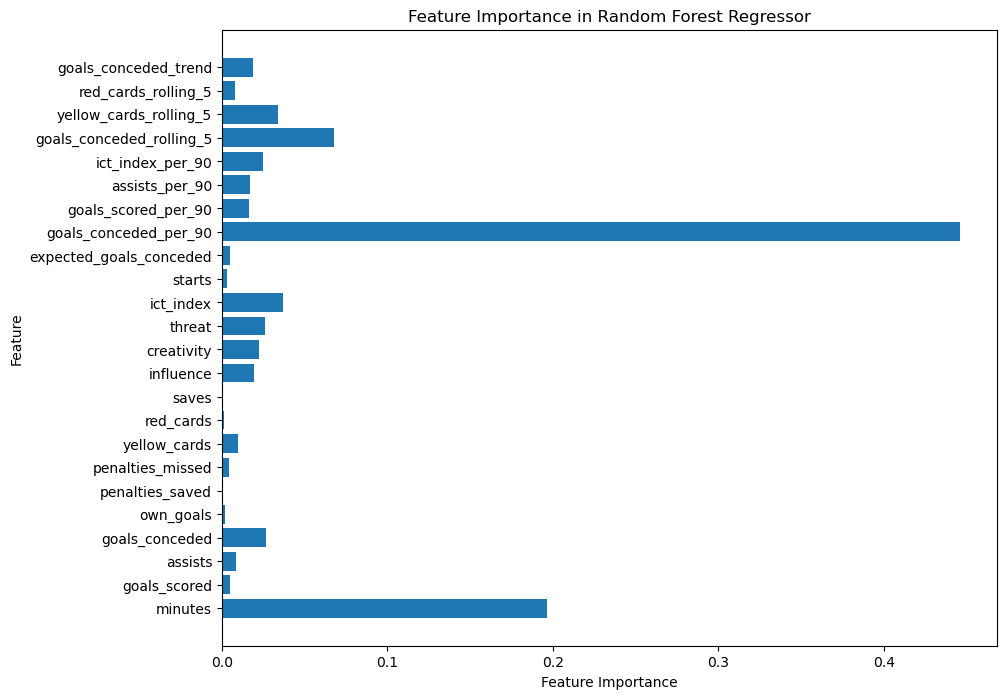

In [261]:
# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_importances_rf)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()

### Thoughts:
* Goals conceded  per 90 is expected to be THE feature to predict  clean sheets per 90.
* Minutes  played is interesting.  There may be groups of defenders that work better in some situations that in others.
* Rolling trend data also seems to have predictive power.

### Fantasy insight
* Assists may distinguish defensive players that are able to contribute to offensive plays and would be much more valuable.

### Conclusions and Next Steps
After running the first 2 models again on the updated Drop list:
1. Rather than run a regression model on the same target, as I did in the first iteration using Ridge, I am interest in exploring if there are different defender player specializations and will first need to test the hypothesis: are there different playmaker styles of defenders (offensive attack vs defensive stopping).
2. I need to revisit feature engineering.
3. Test the data against various models.
4. Stack rank the players by style in the 'Defense Special Score'. 